# version 9: 10/26 – 

ver8のpredictを修正したバージョン

### Libraries

In [1]:
import os
import sys
import math
import time
import yaml
import errno
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# set random seed
fix_seed = 1111
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# set device 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


### (Load a past model)

In [2]:
'''
This code is used only for loading the model and checking its prediction.
'''
# import pandas as pd

# # set name of the model
# model_num = 9

# # load the model and its loss
# model = torch.load('/Users/koki/PycharmProjects/MasterThesis/models/model_' + str(model_num) + '.pth')
# loss = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='losses', usecols=[model_num-1])
# loss = loss.iloc[:,0].to_list()

'\nThis code is used only for loading the model and checking its prediction.\n'

### Import parameters and data

In [3]:
# load parameters
with open('/Users/koki/PycharmProjects/MasterThesis/params/config_lstm.yml', 'r') as yml:
    yaml_data = yaml.safe_load(yml)

In [4]:
# import data
df = pd.read_csv('/Users/koki/PycharmProjects/MasterThesis/data/preprocessed/201601to202309_10areas_for_analysis.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
# choose hours to use
time_list = yaml_data['dataset']['time_list']
if time_list != 'all':
    df = df.loc[df.index.hour.isin(time_list)]

### Define Dataset

In [206]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, seq_len_src=56, seq_len_tgt=8, lag_len=8):
        self.seq_len_src = seq_len_src
        self.lag_len = lag_len
        self.seq_len_tgt = seq_len_tgt
        self.df = torch.tensor(dataframe.values).float()
        self.len = math.floor((len(self.df) - self.seq_len_src - self.seq_len_tgt) / self.lag_len) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        if type(i) == slice:
            raise Exception('Exception: Expected int, inputted slice!')
            
        X = self.df[i*self.lag_len:i*self.lag_len+self.seq_len_src]
        Y = self.df[i*self.lag_len+self.seq_len_src:i*self.lag_len+self.seq_len_src+self.seq_len_tgt]
        
        return X, Y
    
    def input_size(self):
        return self.df.shape[1]

### Split data

In [207]:
batch_size = yaml_data['dataset']['batch_size']
seq_len_src = yaml_data['dataset']['seq_len_src']
seq_len_tgt = yaml_data['dataset']['seq_len_tgt']
lag_len = yaml_data['dataset']['lag_len']

# train
train_start = yaml_data['dataset']['train_start']
train_end = yaml_data['dataset']['train_end']
# validation
valid_start = yaml_data['dataset']['valid_start']
valid_end = yaml_data['dataset']['valid_end']
# test
test_start = yaml_data['dataset']['test_start']
test_end = yaml_data['dataset']['test_end']

# split df into train, valid and test data
# train
df_train = df.loc[train_start:train_end].copy()
# valid
df_valid = df.loc[valid_start:valid_end].copy()
df_valid = pd.concat([df_train.iloc[-seq_len_src:, :], df_valid])  # validデータの1期目から予測するために、前日もテストデータに含める。
# test
df_test = df.loc[test_start:test_end].copy()

# print the fraction of each dataset
print("Train set fraction: {:.3f}%".format(len(df_train)/len(df)*100))
print("Valid set fraction: {:.3f}%".format(len(df_valid)/len(df)*100))
print("Test set fraction: {:.3f}%".format(len(df_test)/len(df)*100))

Train set fraction: 77.456%
Valid set fraction: 12.898%
Test set fraction: 9.682%


### Set dataloader

In [208]:
# create dataset
train_dataset = SequenceDataset(df_train, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=1)
valid_dataset = SequenceDataset(df_valid, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
test_dataset = SequenceDataset(df_test, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
print("Length of each dataset:")
print("    Train:{}, Valid:{}, Test:{}".format(len(train_dataset), len(valid_dataset), len(test_dataset)))

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

# check the shape of a batch
X, y = next(iter(train_loader))
print("Features shape:", X.shape)  # [batch size, sequence length, number of features]
print("Target shape:", y.shape)

Length of each dataset:
    Train:2191, Valid:364, Test:273
Features shape: torch.Size([32, 4, 66])
Target shape: torch.Size([32, 4, 66])


### Define LSTM

In [210]:
# lstm - cat - fc -
class LSTM(nn.Module):
    def __init__(self, num_features_pred, num_features, hidden_units, num_layers):
        super().__init__()
        self.num_features_pred = num_features_pred  # this is the number of features
        self.num_features= num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.num_features_pred,
                            hidden_size=self.hidden_units,
                            batch_first=True,
                            num_layers=self.num_layers,
                            dropout = 0.3)
        self.fc1 = nn.Linear(in_features=self.hidden_units, out_features=self.num_features_pred)
        # self.fc2 = nn.Linear(in_features=128, out_features=self.num_features_pred)
        
        self.fc3 = nn.Linear(in_features=self.num_features, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=256)
        self.fc5 = nn.Linear(in_features=256, out_features=self.num_features_pred)
        
        self.relu = nn.ReLU()

    def forward(self, src):
        batch_size = src.shape[0]

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=device).requires_grad_()
        
        lstm_input = src
        
        # input only population into a lstm layer
        for t in range(lstm_input.shape[1]):
            output, (h0, c0) = self.lstm(lstm_input[:, :, :self.num_features_pred], (h0, c0))  # output size = (batch, sequence_length, hidden_size)
            output = self.fc1(output[:, -1:, :])
            output = self.relu(output)  # output size = (batch, 1, num_features_pred)
        
            # outputの一期分を付け加えて、最初の1期を消す
            output = torch.cat([lstm_input[:, 1:, :self.num_features_pred], output], dim=1)
            
            # concat output from lstm and dummies
            lstm_input = torch.cat((output[:, :, :self.num_features_pred], src[:, :, self.num_features_pred:]), dim=2)
        
        # output = self.fc2(output)
        # output = self.relu(output)

        # fc layers
        x = self.fc3(lstm_input)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        
        return x  # x.shape = [batch_size, 1(seq_len), num_features_pred]        

### Define training and prediction

In [211]:
def train(model, data_loader, loss_function):
    total_losses = []
    model.train()
    for src, tgt in enumerate(data_loader):
        src = X.to(device)
        tgt = y.to(device)
        
        output = model(src)
        loss = loss_function(output[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_losses.append(loss.item())

    return np.average(total_losses)

# def test_model(data_loader, model, loss_function):
#     num_batches = len(data_loader)
#     total_loss = 0

#     model.eval()
#     with torch.no_grad():
#         for X, y in data_loader:
#             X = X.to(device)
#             y = y.to(device)
#             output = model(X[:,:,0:10], X[:,:,10:])
#             total_loss += math.sqrt(loss_function(output[:, :, 0:10], y[:, :, 0:10]).item())

#     avg_loss = total_loss / num_batches
#     test_losses.append(avg_loss)
#     # print(f"Test loss: {avg_loss}")


def predict(model, test_dataset, num_features_pred):
    model.eval()
    with torch.no_grad():   
        all_outputs = torch.zeros(1, num_features_pred).to(device)
        for t in tqdm(range(len(test_dataset))):  # (len(df_test)-8)/8 = 92回予測が必要
            src = test_dataset[t][0].float().to(device)
            tgt = test_dataset[t][1].float().to(device)
            
            # add a batch size of 1 for the encoder (= [1, :, :])
            src = src.unsqueeze(0)
            tgt = tgt.unsqueeze(0)
            
            seq_len_src = src.shape[1]
            seq_len_tgt = tgt.shape[1]

            # initialize tensor for predictions
            outputs = torch.zeros(seq_len_tgt, num_features_pred).to(device)  # outputs.shape =  [seq_len, num_features_pred]
            # decode input_tensor
            lstm_input = src[:, -1:, :]

            for t in range(seq_len_tgt):
                output = model(lstm_input)   # output.shape = [batch_size, 1(seq_len), num_features_pred]
                outputs[t] = output[-1, :, :]
                # decoder input at the next period = (location output from prediction) + (acurate dummy input from test data)
                lstm_input = torch.cat((output[:, :, 0:num_features_pred], tgt[:, t:t+1, num_features_pred:]), dim=2)

            all_outputs = torch.cat([all_outputs, outputs], dim=0)
        
    return all_outputs[1:, :num_features_pred]

### Define parameters

In [212]:
# set hyper parameters
learning_rate = yaml_data['training']['learning_rate']
n_epochs = yaml_data['training']['n_epochs']
hidden_size = yaml_data['model']['hidden_size']
num_layers = yaml_data['model']['num_layers']
num_features_pred = yaml_data['training']['num_features_pred']
dropout = yaml_data['model']['dropout']
loss_calculation = yaml_data['training']['loss_calculation']
num_features=df_train.shape[1]

model = LSTM(num_features_pred=num_features_pred, 
                              num_features=num_features, 
                              hidden_units=hidden_size, 
                              num_layers=num_layers).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [213]:
start = time.time()

train_losses = []
with trange(n_epochs) as tr:
    for it in tr: 
        loss = train(model, train_loader, loss_function)
        
        # convert to RMSE
        loss = math.sqrt(loss)
        
        train_losses.append(loss)
        
        # progress bar 
        tr.set_postfix(loss="{0:.3f}".format(loss))
        
end = time.time()
t = math.floor(end-start)

elapsed_hour = t // 3600
elapsed_minute = (t % 3600) // 60
elapsed_second = (t % 3600 % 60)

elapsed_time = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it, loss=49771.395]


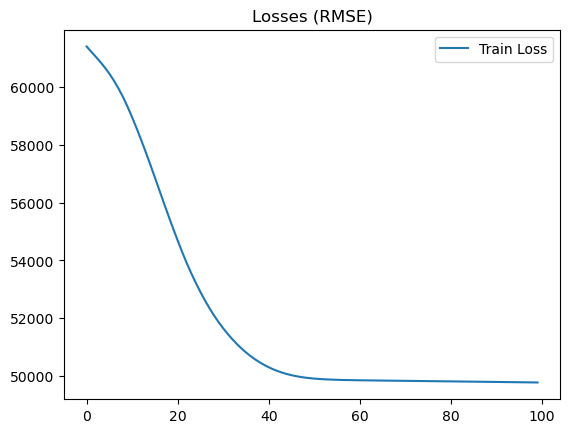

In [214]:
plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
plt.title('Losses (RMSE)')
plt.legend()
plt.show()

### Predict

In [215]:
# make y_true df
y_true = df_test.iloc[seq_len_tgt:, 0:num_features_pred]

# make y_pred df
pred = predict(model=model, data_loader = valid_loader, num_features_pred = num_features_pred).cpu()
y_pred = pd.DataFrame(pred, columns=df.columns[0:num_features_pred], index=y_true.index).add_prefix('pred_')

  0%|          | 0/273 [00:00<?, ?it/s]

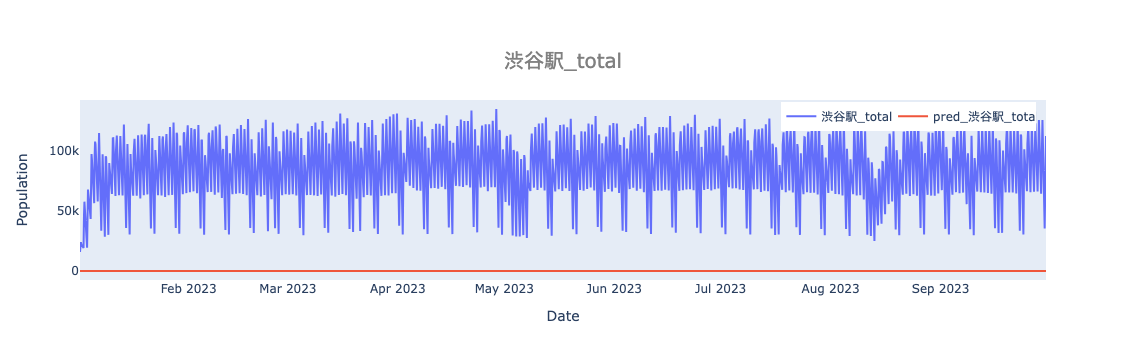

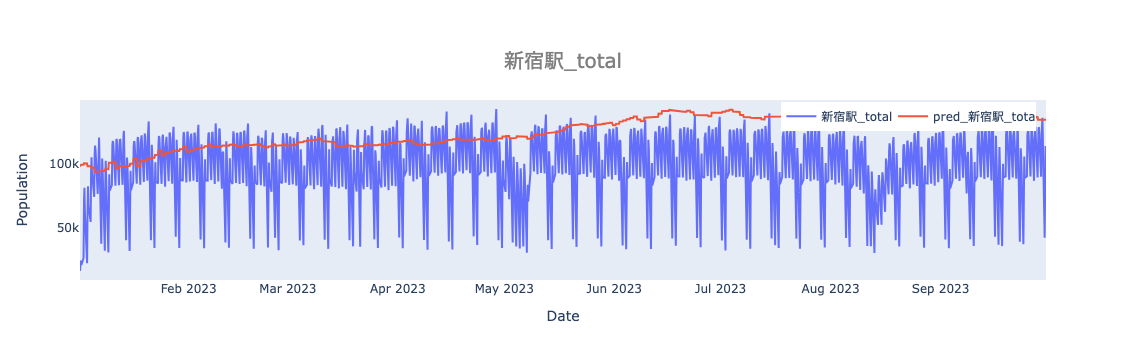

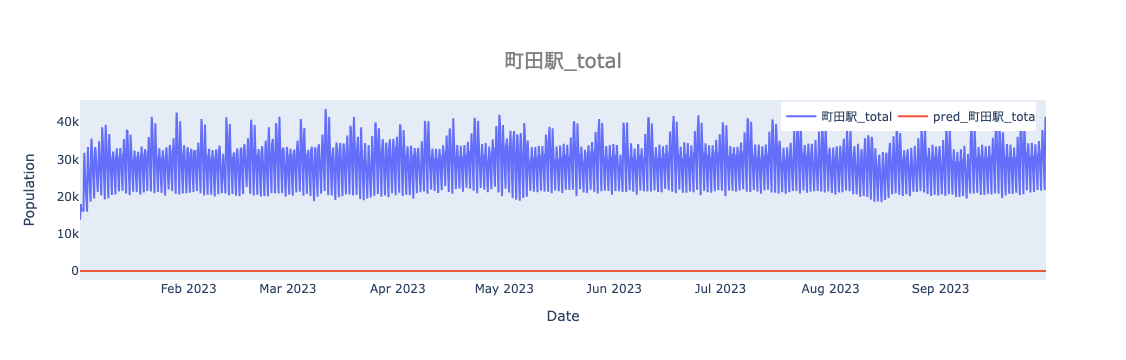

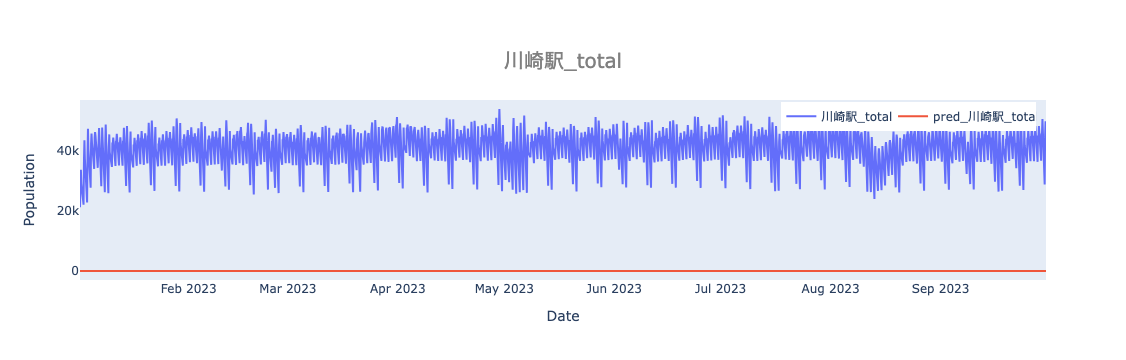

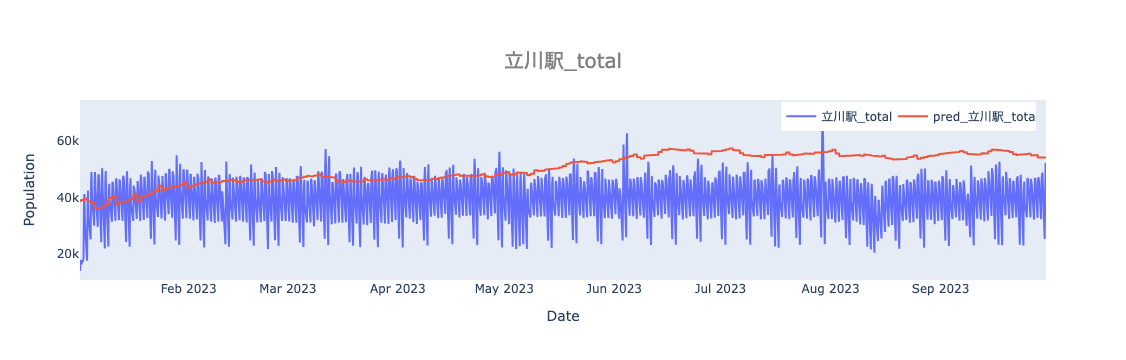

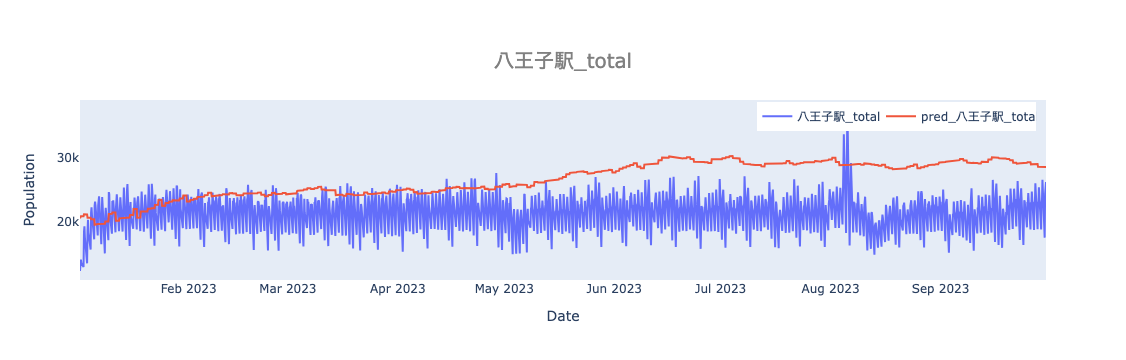

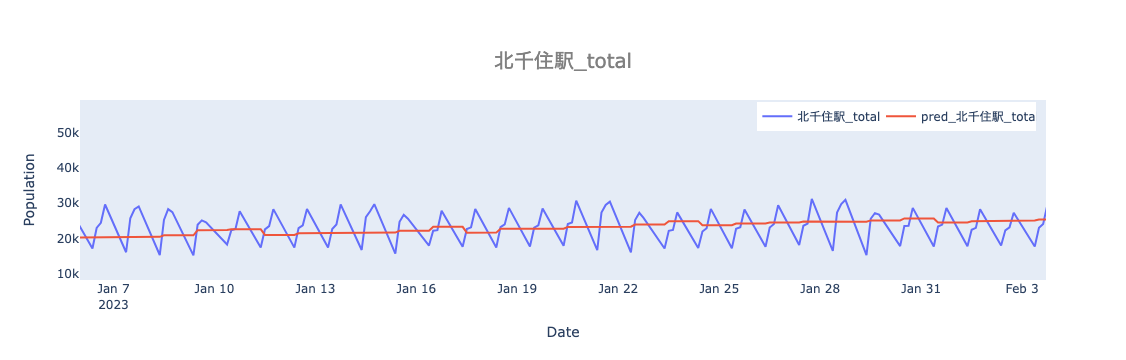

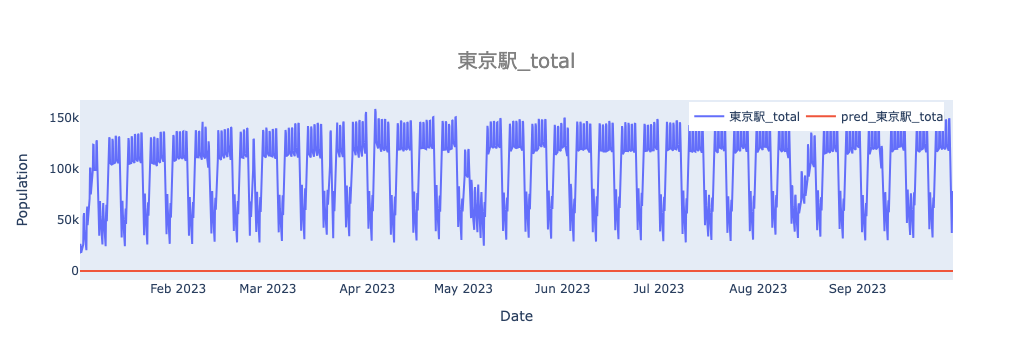

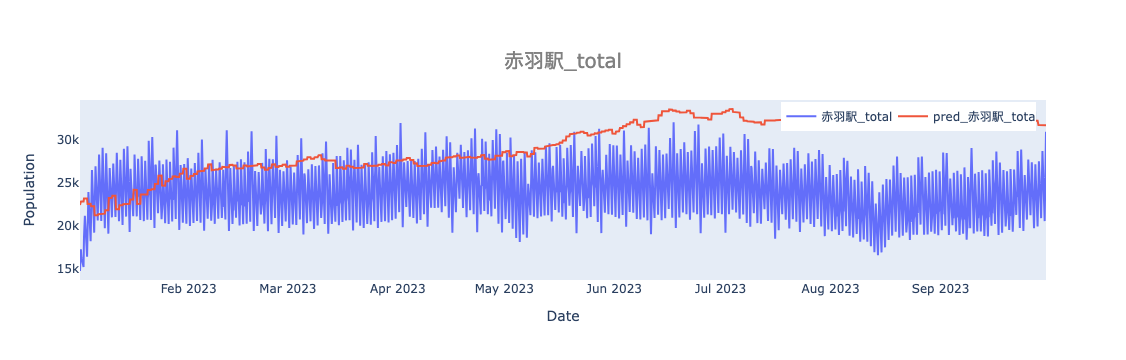

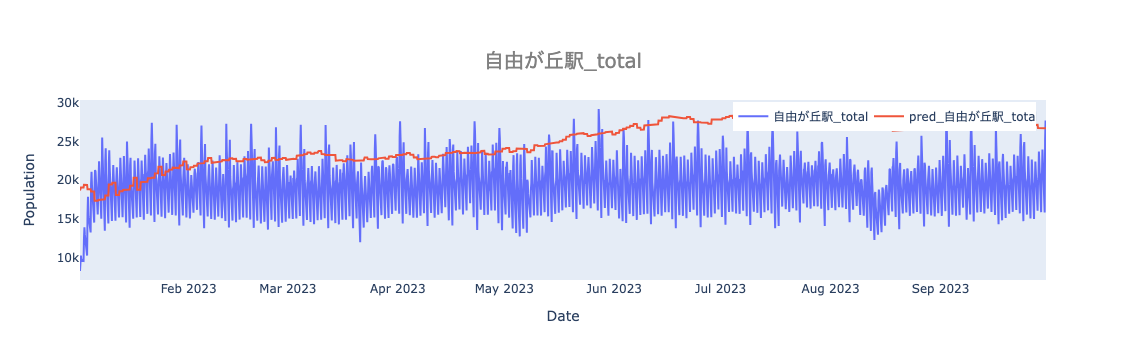

In [216]:
# plot with plotly     
for i in range(y_pred.shape[1]):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true.iloc[:, i], name=y_true.columns[i]))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.iloc[:, i], name=y_pred.columns[i]))
    fig.update_xaxes(title="Date",showgrid=False)
    fig.update_yaxes(title="Population", showgrid=False)
    fig.update_layout(legend=dict(x=0.99,
                              y=0.99,
                              xanchor='right',
                              yanchor='top',
                              orientation='h',
                              ),
                      hovermode='x unified',
                      title=dict(text=y_true.columns[i],
                                 font=dict(size=20, color='grey'),
                                 xref='paper', # container or paper
                                 x=0.5,
                                 y=0.85,
                                 xanchor='center'
                                )
                     )
    fig.show()

### Calculate MSE and MAE by actual values

In [121]:
print('------------MSE------------')
mse = []
for i in range(y_true.shape[1]):
    mse.append(mean_squared_error(y_true.iloc[:,i], y_pred.iloc[:,i], squared=False))
    print(y_true.columns[i], ':', mse[i])
print('Average :', np.mean(mse))
    
print('------------MAE------------')
mae= []
for i in range(y_true.shape[1]):
    mae.append(mean_absolute_error(y_true.iloc[:,i], y_pred.iloc[:,i]))
    print(y_true.columns[i], ':', mae[i])
print('Average :', np.mean(mae))

------------MSE------------
渋谷駅_total : 34183.61144811126
新宿駅_total : 44418.98011608956
町田駅_total : 7179.594962960813
川崎駅_total : 9918.840530159112
立川駅_total : 10689.1017286789
八王子駅_total : 21970.767513203322
北千住駅_total : 6091.2287637171885
東京駅_total : 77048.71544654109
赤羽駅_total : 24137.44444332454
自由が丘駅_total : 20362.723073661313
Average : 25600.10080264471
------------MAE------------
渋谷駅_total : 26378.42327724359
新宿駅_total : 38240.69785585508
町田駅_total : 5337.913226340716
川崎駅_total : 8261.54206909627
立川駅_total : 8054.812351548191
八王子駅_total : 21780.56010133181
北千住駅_total : 4535.893394609948
東京駅_total : 65191.92919206445
赤羽駅_total : 23921.252747252747
自由が丘駅_total : 20054.195193120577
Average : 22175.721940846335


### Calculate RMSE and MAE by benchmark

In [ ]:
# make benchmark

num_features_pred = yaml_data['training']['num_features_pred']

# get df for the past one month
b_start = (datetime.datetime.strptime(test_start, '%Y-%m-%d') + datetime.timedelta(days=-30)).strftime('%Y-%m-%d %H:%M:%S')
b_end = (datetime.datetime.strptime(test_start, '%Y-%m-%d') + datetime.timedelta(hours=-3)).strftime('%Y-%m-%d %H:%M:%S')
benchmark_daterange = pd.date_range(start=b_start, end=b_end, freq='3H')
_df = df.loc[benchmark_daterange[0]:benchmark_daterange[-1]]

# calculate RMSE (y_true = the mean of the past one month, y_pred = the mean of all the predicted values)
dow = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']
d = dow[y_pred.index[0].weekday()]
bench = mean_absolute_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean())
print(d, 'RMSE: ', mean_squared_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean(), squared=False))
print(d, 'MAE: ', bench)
print('absolute_error')
for i in range(y_true.shape[1]):
    print(f'   {y_true.columns[i]}: {np.abs(_df[_df[d]==1].mean()[:num_features_pred][i] - y_pred.iloc[:,:num_features_pred].mean()[i])}')

### Save the results and the model 

In [ ]:
'''
save the model, its loss, and params used
'''
# count the number of files in the directory
path = '/Users/koki/PycharmProjects/MasterThesis/models'

# read parameter data
df1 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='params')

# set a model name
num = 'model_' + str(df1.shape[0]+1).zfill(2)

# get params used in this file
series = pd.concat([pd.Series(yaml_data['dataset']), pd.Series(yaml_data['model']), pd.Series(yaml_data['training'])])
params = pd.DataFrame(series).T
params.insert(0, "num", num)
params.insert(1, "file_name", "LSTM_ver8")  ###### the name of this file! ######
params.insert(2, "date_of_execution", datetime.datetime.today().strftime("%Y-%m-%d %H:%M"))
params.insert(3, "execution_time", elapsed_time)
params.insert(params.shape[1], "final_train_loss" , math.floor(train_losses[-1]))
params.insert(params.shape[1], "final_valid_loss" , math.floor(valid_losses[-1]))
params.insert(params.shape[1], "mse_observation" , math.floor(np.mean(mse)))
params.insert(params.shape[1], "mae_observation" , math.floor(np.mean(mae)))
params.insert(params.shape[1], "mae_benchmark" , math.floor(bench))
df1 = pd.concat([df1, params])

# read loss data
df2 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='train_losses')
df2 = pd.concat([df2, pd.Series(train_losses, name=num)], axis=1)

# read valid loss data
df3 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='valid_losses')
df3 = pd.concat([df3, pd.Series(valid_losses, name=num)], axis=1)

# export the data 
with pd.ExcelWriter('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx') as writer:
    df1.to_excel(writer, sheet_name='params', index=False)
    df2.to_excel(writer, sheet_name='train_losses', index=False)
    df3.to_excel(writer, sheet_name='valid_losses', index=False)

# save the model
torch.save(model, '/Users/koki/PycharmProjects/MasterThesis/models/' + num + '.pth')

In [ ]:
# notification
# !afplay '/Users/koki/Documents/セレナと一緒/result_message.m4a'

In [ ]:
print('Done!')

### Memo

In [ ]:
'''
'''

### Insight

In [ ]:
'''
'''

### To Do

In [ ]:
'''
'''